In [3]:
import os
os.environ["WANDB_NOTEBOOK_NAME"]="finetuning"

In [4]:
config = {
    "architecture": "beomi/Llama-3-Open-Ko-8B-Instruct-preview",
    "dataset": "NAS 업로드 모든 데이터",
    "max_seq_length": 2048, # Choose any! We auto support RoPE Scaling internally!
    "load_in_8bit": True, # Use 4bit quantization to reduce memory usage. Can be False.
    "lora_use": True,
    "lora_use": True,
    "lora_rank_and_alpha": [16, 32],
    "lora_target_modules": ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    "epochs": 5,
    "batch_size": 32,
    "gradient_accumulation_steps": 16,
    "learning_rate": 2e-5,
    "seed": 3407,
}

In [5]:
import wandb 

# # wandb로 추적하기 위한 코드
# wandb.require("core")


# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="kollm-SFT",

    # track hyperparameters and run metadata
    config=config
)


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find finetuning.
wandb: Currently logged in as: schaeck (schaeck-dongguk-university). Use `wandb login --relogin` to force relogin


In [6]:
import torch

# CUDA 장치의 주요 버전과 부 버전을 가져옵니다.
major_version, minor_version = torch.cuda.get_device_capability()
major_version, minor_version

(8, 9)

In [7]:
import torch

if torch.cuda.is_available():
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device name: {torch.cuda.get_device_name(0)}")
    print(f"Device capability: {torch.cuda.get_device_capability(0)}")
    print(f"bfloat16 support: {torch.cuda.is_bf16_supported()}")
else:
    print("CUDA not available")

CUDA available: True
Device count: 2
Current device name: NVIDIA RTX 6000 Ada Generation
Device capability: (8, 9)
bfloat16 support: True


In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

max_seq_length = 4096  # 최대 시퀀스 길이를 설정합니다.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
load_in_4bit = True  # 4bit 양자화 로드 여부를 설정합니다.


quantization_config = BitsAndBytesConfig(
    load_in_4bit=config["load_in_8bit"],
)

model = AutoModelForCausalLM.from_pretrained(
    config["architecture"],
    quantization_config=quantization_config,
)

model.config.max_position_embeddings = max_seq_length

tokenizer = AutoTokenizer.from_pretrained(config["architecture"])

/home/ragllama/.conda/envs/kollm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
if config["lora_use"] :
    from peft import get_peft_model, LoraConfig

    lora_config = LoraConfig(
        r = config["lora_rank_and_alpha"][0], # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
        target_modules = config["lora_target_modules"],
        lora_alpha = config["lora_rank_and_alpha"][1],
        lora_dropout = 0, # Supports any, but = 0 is optimized
        bias = "none",    # Supports any, but = "none" is optimized
        use_rslora=False
    )
    
    model = get_peft_model(model, lora_config)
    
    # gradient checkpointing을 모델의 config에 직접 설정합니다.
    model.config.gradient_checkpointing = True

In [16]:
promopt_template = """instruction:{instruction} ### input:{input} ### Response:{output}"""


EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

def foramtting_prompts_end_token(examples):
    before_text = examples["text"]
    texts = []
    for text in before_text:
        text += EOS_TOKEN
        texts.append(text)
    return { "text": texts, }
        
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = promopt_template.format(instruction=instruction, input=input, output=output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }


from datasets import load_dataset, concatenate_datasets

dataset1 = load_dataset("json", data_files="dataset_merge/merged_output.jsonl")
dataset1 = dataset1.map(foramtting_prompts_end_token, batched = True,) # 엔드 토큰 추가
dataset1 = dataset1['train']

print(dataset1)

dataset2 = load_dataset("Bingsu/ko_alpaca_data", split = "train")
dataset2 = dataset2.map(formatting_prompts_func, batched = True,) # 엔드 토큰 추가
print(dataset2)

dataset = concatenate_datasets([dataset1, dataset2])

###
dataset = dataset.select(range(100))
print(dataset)

# 데이터셋을 훈련과 검증 세트로 나누기 (예: 0.01%를 검증 세트로 사용)
dataset_split = dataset.train_test_split(test_size=0.0001, seed=42)

# 훈련 및 검증 데이터셋으로 나누기
train_dataset = dataset_split['train']
valid_dataset = dataset_split['test']

# 데이터셋 정보 출력
print("훈련 데이터셋 크기:", len(train_dataset))
print("검증 데이터셋 크기:", len(valid_dataset))

print("훈련 데이터 10개")
print(train_dataset[:5])

Dataset({
    features: ['instruction', 'input', 'output', 'system', 'text'],
    num_rows: 2097957
})
Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 49620
})
Dataset({
    features: ['instruction', 'input', 'output', 'system', 'text'],
    num_rows: 100
})
훈련 데이터셋 크기: 99
검증 데이터셋 크기: 1
훈련 데이터 10개
{'instruction': ['서울 누적 코로나19 확진자 수는 18일 0시 기준으로 몇 명이야', '투애니원의 해체 후 씨엘이 솔로 데뷔를 한 건 언제야', '포켓돌스튜디오가 가수 송가인의 매니지먼트를 맡은 건 언제야', '몇 개의 전자푸붐 산업단지가 경기도에 추가로 지정됐어', '엔씨소프트의 리니지2M의 미국 매출은 어떻게 돼'], 'input': ['18일 국내 신종 코로나바이러스 감염증(코로나19) 확진자가 15명 증가한 것으로 집계됐다. \n\n집단 감염이 일어난 서울 이태원 클럽 관련 확산세가 다소 잦아들면서 신규 확진자는 사흘째 10명대를 유지했다. \n\n중앙방역대책본부(방대본)는 이날 0시 기준 코로나19 확진자가 전날 0시보다 15명 증가해 국내 누적 확진자 수는 1만1천65명이라고 밝혔다. \n\n신규 확진자 수는 16일 19명, 17일 13명에 이어 이날까지 10명대를 기록했다. \n\n이태원 클럽 관련 초발 환자 중 한 명인 경기 용인의 66번 환자가 지난 6일 확진 판정을 받은 후 하루 신규 확진자 수는 8일 12명, 9일 18명으로 늘었고, 10∼11일에는 30명대(34명·35명)를 기록했었다. \n\n이어 12∼15일에는 20명대(27명·26명·29명·27명)를 유지하다가 16일부터는 10명대로 안정화하는 추세다. \n\n신규 확진자 15명 중 

In [23]:
from trl import SFTTrainer
from transformers import TrainingArguments

tokenizer.padding_side = "right"  # 토크나이저의 패딩을 오른쪽으로 설정합니다.

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = valid_dataset,
    dataset_text_field = "text",
    max_seq_length = config["max_seq_length"],
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = config["batch_size"],
        gradient_accumulation_steps = config["gradient_accumulation_steps"],
        warmup_steps = 5,
            num_train_epochs=1, # Set num_train_epochs = 1 for full training runs
        do_eval=True,
        evaluation_strategy="steps",
        logging_steps=1,  # logging 스텝 수
        learning_rate = config["learning_rate"],
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        optim = "adafactor",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = config["seed"],
        output_dir = "outputs",
    ),
)

/home/ragllama/.conda/envs/kollm/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/ragllama/.conda/envs/kollm/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/ragllama/.conda/envs/kollm/lib/python3.11/site-packages/transformers/training_args.py:1961: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/home/ragllama/.conda/envs/kollm/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/home/raglla

In [24]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA RTX 6000 Ada Generation. Max memory = 47.507 GB.
6.307 GB of memory reserved.


In [25]:
# 학습 전 기본 모델 성능 확인
inputs = tokenizer(
[
    promopt_template.format(
        instruction="주어진 개념 세트를 이용하여 문장을 생성하세요.", # instruction
        input="개념 세트: 카페 이름, 대, 이겼", # input
        output="", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['<|begin_of_text|>instruction:주어진 개념 세트를 이용하여 문장을 생성하세요. ### input:개념 세트: 카페 이름, 대, 이겼 ### Response:카페 이름이 대를 이겼다.  (이름) 카페 이름이 대를 이겼다.  (이름) 카페 이름이 대를 이겼다.  (이름) 카페 이름이 대를 이겼다.  (이름) 카페 이름이']

In [26]:
# alpaca_prompt = Copied from above
inputs = tokenizer(
[
    promopt_template.format(
        instruction="Continue the fibonnaci sequence.", # instruction
        input="1, 1, 2, 3, 5, 8", # input
        output="", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>instruction:Continue the fibonnaci sequence. ### input:1, 1, 2, 3, 5, 8 ### Response:13
The Fibonacci sequence is a series of numbers in which each number is the sum of the two preceding numbers. The sequence starts with 0 and 1, and each subsequent number is the sum of the previous two numbers. The sequence is often used in mathematics, computer science, and other fields to model natural phenomena, such as the growth of populations, the spread of diseases, and the behavior of financial markets. The sequence is also used in art, architecture, and other fields to create aesthetically pleasing patterns and designs. The sequence is often used in music, dance, and other fields to create aesthetically pleasing patterns and


In [28]:
trainer_stats = trainer.train()  # 모델을 훈련시키고 통계를 반환합니다.

RuntimeError: Please do not edit specific areas of the Unsloth codebase or you will get CUDA segfaults.

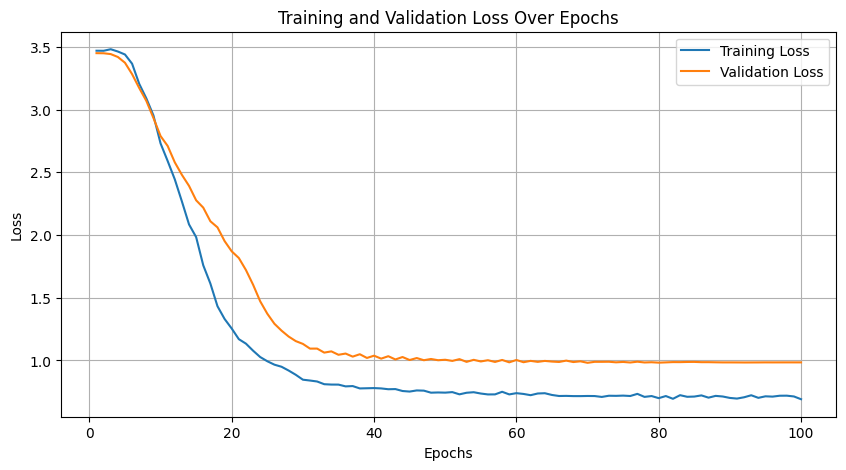

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(trainer.state.log_history)

train_loss = df ['loss'].dropna()
val_loss = df ['eval_loss'].dropna()

epochs = range(1, len(train_loss) + 1)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1739.2429 seconds used for training.
28.99 minutes used for training.
Peak reserved memory = 46.357 GB.
Peak reserved memory for training = 31.117 GB.
Peak reserved memory % of max memory = 97.579 %.
Peak reserved memory for training % of max memory = 65.5 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [14]:
# 학습 전 기본 모델 성능 확인
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "주어진 개념 세트를 이용하여 문장을 생성하세요.", # instruction
        "개념 세트: 카페 이름, 대, 이겼", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n주어진 개념 세트를 이용하여 문장을 생성하세요.\n\n### Input:\n개념 세트: 카페 이름, 대, 이겼\n\n### Response:\n이겼다는 카페 이름이 대박 카페다.<|end_of_text|>']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [15]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the fibonnaci sequence.

### Input:
1, 1, 2, 3, 5, 8

### Response:
9, 13, 21, 34, 55, 89, 144, 233, 377, 610, 985, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46362, 75025, 12193, 19601, 31301, 50550, 82029, 13496, 21708, 35209, 57028, 9344, 15142, 24193, 39241, 62703, 10001,


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [16]:
# 로라 모델 저장

model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [20]:
# model.save_pretrained(lora_adapter, save_adapter=True, save_config=True)

base_model, _ = FastLanguageModel.from_pretrained(
    model_name = config["architecture"], # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = config["max_seq_length"],
)

model_to_merge = model.from_pretrained(base_model, "lora_model")

merged_model = model.merge_and_unload()

==((====))==  Unsloth: Fast Llama patching release 2024.7
   \\   /|    GPU: NVIDIA RTX 6000 Ada Generation. Max memory: 47.507 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.25. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


/home/ragllama/.conda/envs/kollm/lib/python3.11/site-packages/accelerate/utils/modeling.py:1384: UserWarning: Current model requires 33554432.0 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `load_in_8bit_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(merged_model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = merged_model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

# 아래부터는 무시

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

    # alpaca_prompt = You MUST copy from above!

    inputs = tokenizer(
    [
        alpaca_prompt.format(
            "What is a famous tall tower in Paris?", # instruction
            "", # input
            "", # output - leave this blank for generation!
        ),
    ], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
    tokenizer.batch_decode(outputs)

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q5_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. `ChatML` for ShareGPT datasets, [conversational notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing)
8. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. Gemma 6 trillion tokens is 2.5x faster! [free Colab](https://colab.research.google.com/drive/10NbwlsRChbma1v55m8LAPYG15uQv6HLo?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>